# Importing Libraries

In [1]:
import os
import sys
import time
import torch
import random
import network
import argparse
import platform
import ivtmetrics # You must "pip install ivtmetrics" to use
import dataloader
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim
import numpy as np
# import lpips
import piq
from torchvision.utils import save_image
from torchvision.utils import save_image
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Argument Parser

## In case of running using cmd

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
!export CUDA_VISIBLE_DEVICES=1

In [3]:
#%% @args parsing
parser = argparse.ArgumentParser()

parser.add_argument('--model', type=str, default='rendezvous', choices=['rendezvous'], help='Model name?')
parser.add_argument('--version', type=int, default=0,  help='Model version control (for keeping several versions)') 
parser.add_argument('--hr_output', action='store_true', help='Whether to use higher resolution output (32x56) or not (8x14). Default: False')
parser.add_argument('--use_ln', action='store_true', help='Whether to use layer norm or batch norm in AddNorm() function. Default: False')
parser.add_argument('--decoder_layer', type=int, default=8, help='Number of MHMA layers ') 
# job
parser.add_argument('-t', '--train', action='store_true', help='to train.')
parser.add_argument('-e', '--test',  action='store_true', help='to test')
parser.add_argument('--val_interval', type=int, default=1,  help='(for hp tuning). Epoch interval to evaluate on validation data. set -1 for only after final epoch, or a number higher than the total epochs to not validate.')
# data
parser.add_argument('--data_dir', type=str, default='/path/to/dataset', help='path to dataset?')
parser.add_argument('--dataset_variant', type=str, default='cholect45-crossval', choices=['cholect50', 'cholect45', 'cholect50-challenge', 'cholect50-crossval', 'cholect45-crossval'], help='Variant of the dataset to use')
parser.add_argument('-k', '--kfold', type=int, default=1,  choices=[1,2,3,4,5,], help='The test split in k-fold cross-validation')
parser.add_argument('--image_width', type=int, default=448, help='Image width ')  
parser.add_argument('--image_height', type=int, default=256, help='Image height ')  
parser.add_argument('--image_channel', type=int, default=3, help='Image channels ')  
parser.add_argument('--num_tool_classes', type=int, default=6, help='Number of tool categories')
parser.add_argument('--num_verb_classes', type=int, default=10, help='Number of verb categories')
parser.add_argument('--num_target_classes', type=int, default=15, help='Number of target categories')
parser.add_argument('--num_triplet_classes', type=int, default=100, help='Number of triplet categories')
parser.add_argument('--augmentation_list', type=str, nargs='*', default=['original', 'vflip', 'hflip', 'contrast', 'rot90'], help='List augumentation styles (see dataloader.py for list of supported styles).')
# hp
parser.add_argument('-b', '--batch', type=int, default=32,  help='The size of sample training batch')
parser.add_argument('--epochs', type=int, default=100,  help='How many training epochs?')
parser.add_argument('-w', '--warmups', type=int, nargs='+', default=[9,18,58], help='List warmup epochs for tool, verb-target, triplet respectively')
parser.add_argument('-l', '--initial_learning_rates', type=float, nargs='+', default=[0.01, 0.01, 0.01], help='List learning rates for tool, verb-target, triplet respectively')
parser.add_argument('--weight_decay', type=float, default=1e-5,  help='L2 regularization weight decay constant')
parser.add_argument('--decay_steps', type=int, default=10,  help='Step to exponentially decay')
parser.add_argument('--decay_rate', type=float, default=0.99,  help='Learning rates weight decay rate')
parser.add_argument('--momentum', type=float, default=0.95,  help="Optimizer's momentum")
parser.add_argument('--power', type=float, default=0.1,  help='Learning rates weight decay power')
# weights
parser.add_argument('--pretrain_dir', type=str, default='', help='path to pretrain_weight?')
parser.add_argument('--test_ckpt', type=str, default=None, help='path to model weight for testing')
# device
parser.add_argument('--gpu', type=str, default="0",  help='The gpu device to use. To use multiple gpu put all the device ids comma-separated, e.g: "0,1,2" ')
FLAGS, unparsed = parser.parse_known_args()
import torch

# Parameters Definition

In [4]:
#%% @params definitions
is_train        = FLAGS.train
is_test         = FLAGS.test
dataset_variant = FLAGS.dataset_variant
data_dir        = FLAGS.data_dir
kfold           = FLAGS.kfold if "crossval" in dataset_variant else 0
version         = FLAGS.version
hr_output       = FLAGS.hr_output
use_ln          = FLAGS.use_ln
batch_size      = FLAGS.batch
pretrain_dir    = FLAGS.pretrain_dir
test_ckpt       = FLAGS.test_ckpt
weight_decay    = FLAGS.weight_decay
learning_rates  = FLAGS.initial_learning_rates
warmups         = FLAGS.warmups
decay_steps     = FLAGS.decay_steps
decay_rate      = FLAGS.decay_rate
power           = FLAGS.power
momentum        = FLAGS.momentum
epochs          = FLAGS.epochs
gpu             = FLAGS.gpu
image_height    = FLAGS.image_height
image_width     = FLAGS.image_width
image_channel   = FLAGS.image_channel
num_triplet     = FLAGS.num_triplet_classes
num_tool        = FLAGS.num_tool_classes
num_verb        = FLAGS.num_verb_classes
num_target      = FLAGS.num_target_classes
val_interval    = FLAGS.epochs-1 if FLAGS.val_interval==-1 else FLAGS.val_interval
set_chlg_eval   = True if "challenge" in dataset_variant else False # To observe challenge evaluation protocol
gpu             = ",".join(str(FLAGS.gpu).split(","))
decodelayer     = FLAGS.decoder_layer
addnorm         = "layer" if use_ln else "batch"
modelsize       = "high" if hr_output else "low"
FLAGS.multigpu  = len(gpu) > 1  # not yet implemented !
mheaders        = ["","l", "cholect", "k"]
margs           = [FLAGS.model, decodelayer, dataset_variant, kfold]
wheaders        = ["norm", "res"]
wargs           = [addnorm, modelsize]
modelname       = "_".join(["{}{}".format(x,y) for x,y in zip(mheaders, margs) if len(str(y))])+"_"+\
                  "_".join(["{}{}".format(x,y) for x,y in zip(wargs, wheaders) if len(str(x))])
model_dir       = "./__checkpoint__/run_{}".format(version)

if not os.path.exists(model_dir): os.makedirs(model_dir)
resume_ckpt     = None
ckpt_path       = os.path.join(model_dir, '{}.pth'.format(modelname))
logfile         = os.path.join(model_dir, '{}.log'.format(modelname))
data_augmentations      = FLAGS.augmentation_list 
iterable_augmentations  = []
print("Configuring network ...")

#%% @functions (helpers)
def assign_gpu(gpu=None):  
    os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu) 
    os.environ['TF_ENABLE_WINOGRAD_NONFUSED'] = '1' 
    

def get_weight_balancing(case='cholect50'):
    # 50:   cholecT50, data splits as used in rendezvous paper
    # 50ch: cholecT50, data splits as used in CholecTriplet challenge
    # 45cv: cholecT45, official data splits (cross-val)
    # 50cv: cholecT50, official data splits (cross-val)
    switcher = {
        'cholect50': {
            'tool'  :   [0.08084519, 0.81435289, 0.10459284, 2.55976864, 1.630372490, 1.29528455],
            'verb'  :   [0.31956735, 0.07252306, 0.08111481, 0.81137309, 1.302895320, 2.12264151, 1.54109589, 8.86363636, 12.13692946, 0.40462028],
            'target':   [0.06246232, 1.00000000, 0.34266478, 0.84750219, 14.80102041, 8.73795181, 1.52845100, 5.74455446, 0.285756500, 12.72368421, 0.6250808,  3.85771277, 6.95683453, 0.84923888, 0.40130032]
        },
        'cholect50-challenge': {
            'tool':     [0.08495163, 0.88782288, 0.11259564, 2.61948830, 1.784866470, 1.144624170],
            'verb':     [0.39862805, 0.06981640, 0.08332925, 0.81876204, 1.415868390, 2.269359150, 1.28428410, 7.35822511, 18.67857143, 0.45704490],
            'target':   [0.07333818, 0.87139287, 0.42853950, 1.00000000, 17.67281106, 13.94545455, 1.44880997, 6.04889590, 0.326188650, 16.82017544, 0.63577586, 6.79964539, 6.19547658, 0.96284208, 0.51559559]
        },
        'cholect45-crossval': {
            1: {
                'tool':     [0.08165644, 0.91226868, 0.10674758, 2.85418156, 1.60554885, 1.10640067],
                'verb':     [0.37870137, 0.06836869, 0.07931255, 0.84780024, 1.21880342, 2.52836879, 1.30765704, 6.88888889, 17.07784431, 0.45241117],
                'target':   [0.07149629, 1.0, 0.41013597, 0.90458015, 13.06299213, 12.06545455, 1.5213205, 5.04255319, 0.35808332, 45.45205479, 0.67493897, 7.04458599, 9.14049587, 0.97330595, 0.52633249]
                },
            2: {
                'tool':     [0.0854156, 0.89535362, 0.10995253, 2.74936869, 1.78264429, 1.13234529],
                'verb':     [0.36346863, 0.06771776, 0.07893261, 0.82842725, 1.33892161, 2.13049748, 1.26120359, 5.72674419, 19.7, 0.43189126],
                'target':   [0.07530655, 0.97961957, 0.4325135, 0.99393438, 15.5387931, 14.5951417, 1.53862569, 6.01836394, 0.35184462, 15.81140351, 0.709506, 5.79581994, 8.08295964, 1.0, 0.52689272]
            },
            3: {
                "tool" :   [0.0915228, 0.89714969, 0.12057004, 2.72128174, 1.94092281, 1.12948557],
                "verb" :   [0.43636862, 0.07558554, 0.0891017, 0.81820519, 1.53645582, 2.31924198, 1.28565657, 6.49387755, 18.28735632, 0.48676763],
                "target" : [0.06841828, 0.90980736, 0.38826607, 1.0, 14.3640553, 12.9875, 1.25939394, 5.38341969, 0.29060227, 13.67105263, 0.59168565, 6.58985201, 5.72977941, 0.86824513, 0.47682423]

            },
            4: {
                'tool':     [0.08222218, 0.85414117, 0.10948695, 2.50868784, 1.63235867, 1.20593318],
                'verb':     [0.41154261, 0.0692142, 0.08427214, 0.79895288, 1.33625219, 2.2624166, 1.35343681, 7.63, 17.84795322, 0.43970609],
                'target':   [0.07536126, 0.85398445, 0.4085784, 0.95464422, 15.90497738, 18.5978836, 1.55875831, 5.52672956, 0.33700863, 15.41666667, 0.74755423, 5.4921875, 6.11304348, 1.0, 0.50641118],
            },
            5: {
                'tool':     [0.0804654, 0.92271157, 0.10489631, 2.52302243, 1.60074906, 1.09141982],
                'verb':     [0.50710436, 0.06590258, 0.07981184, 0.81538866, 1.29267277, 2.20525568, 1.29699248, 7.32311321, 25.45081967, 0.46733895],
                'target':   [0.07119395, 0.87450495, 0.43043372, 0.86465981, 14.01984127, 23.7114094, 1.47577277, 5.81085526, 0.32129865, 22.79354839, 0.63304067, 6.92745098, 5.88833333, 1.0, 0.53175798]
            }
        },
        'cholect50-crossval': {
            1:{
                'tool':     [0.0828851, 0.8876, 0.10830995, 2.93907285, 1.63884786, 1.14499484],
                'verb':     [0.29628942, 0.07366916, 0.08267971, 0.83155428, 1.25402434, 2.38358209, 1.34938741, 7.56872038, 12.98373984, 0.41502079],
                'target':   [0.06551745, 1.0, 0.36345711, 0.82434783, 13.06299213, 8.61818182, 1.4017744, 4.62116992, 0.32822238, 45.45205479, 0.67343211, 4.13200498, 8.23325062, 0.88527215, 0.43113306],

            },
            2:{
                'tool':     [0.08586283, 0.87716737, 0.11068887, 2.84210526, 1.81016949, 1.16283571],
                'verb':     [0.30072757, 0.07275414, 0.08350168, 0.80694143, 1.39209979, 2.22754491, 1.31448763, 6.38931298, 13.89211618, 0.39397505],
                'target':   [0.07056703, 1.0, 0.39451115, 0.91977006, 15.86206897, 9.68421053, 1.44483706, 5.44378698, 0.31858714, 16.14035088, 0.7238395, 4.20571429, 7.98264642, 0.91360477, 0.43304307],
            },
            3:{
            'tool':      [0.09225068, 0.87856006, 0.12195811, 2.82669323, 1.97710987, 1.1603972],
                'verb':     [0.34285159, 0.08049804, 0.0928239, 0.80685714, 1.56125608, 2.23984772, 1.31471136, 7.08835341, 12.17241379, 0.43180428],
                'target':   [0.06919395, 1.0, 0.37532866, 0.9830703, 15.78801843, 8.99212598, 1.27597765, 5.36990596, 0.29177312, 15.02631579, 0.64935557, 5.08308605, 5.86643836, 0.86580743, 0.41908257], 
            },
            4:{
                'tool':     [0.08247885, 0.83095539, 0.11050268, 2.58193042, 1.64497676, 1.25538881],
                'verb':     [0.31890981, 0.07380354, 0.08804592, 0.79094077, 1.35928144, 2.17017208, 1.42947103, 8.34558824, 13.19767442, 0.40666428],
                'target':   [0.07777646, 0.95894072, 0.41993829, 0.95592153, 17.85972851, 12.49050633, 1.65701092, 5.74526929, 0.33763901, 17.31140351, 0.83747083, 3.95490982, 6.57833333, 1.0, 0.47139615],
            },
            5:{
                'tool':     [0.07891691, 0.89878025, 0.10267677, 2.53805556, 1.60636428, 1.12691169],
                'verb':     [0.36420961, 0.06825313, 0.08060635, 0.80956984, 1.30757221, 2.09375, 1.33625848, 7.9009434, 14.1350211, 0.41429631],
                'target':   [0.07300329, 0.97128713, 0.42084942, 0.8829883, 15.57142857, 19.42574257, 1.56521739, 5.86547085, 0.32732733, 25.31612903, 0.70171674, 4.55220418, 6.13125, 1.0, 0.48528321],
            }
        }
    }
    return switcher.get(case)
     

Configuring network ...


# Loading and Building Model

In [5]:
# Path to model checkpoint
test_ckpt = 'weights/rendezvous_l8_cholectcholect45-crossval_k1_batchnorm_lowres_180.pth'

# Load base structure model
model = network.Rendezvous('resnet18', hr_output=hr_output, use_ln=use_ln).cuda()
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


#%% performance tracker for hp tuning
benchmark   = torch.nn.Parameter(torch.tensor([0.0]), requires_grad=False)
print("Model built ...")

# Load the checkpoint of the trained model
if os.path.exists(test_ckpt):
    model.load_state_dict(torch.load(test_ckpt) ,  strict=False)

/home/umairnawaz/.conda/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/umairnawaz/.conda/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model built ...


# Define Loss, Activation, and mAP Metrics

In [6]:
# Or constant weights from average of the random sampling of the dataset: we found this to produce better result.
tool_weight     = [0.93487068, 0.94234964, 0.93487068, 1.18448115, 1.02368339, 0.97974447]
verb_weight     = [0.60002400, 0.60002400, 0.60002400, 0.61682467, 0.67082683, 0.80163207, 0.70562823, 2.11208448, 2.69230769, 0.60062402]
target_weight   = [0.49752894, 0.52041527, 0.49752894, 0.51394739, 2.71899565, 1.75577963, 0.58509403, 1.25228034, 0.49752894, 2.42993134, 0.49802647, 0.87266576, 1.36074165, 0.50150917, 0.49802647]


#%% Loss
activation  = nn.Sigmoid()
loss_fn_i   = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(tool_weight).cuda())
loss_fn_v   = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(verb_weight).cuda())
loss_fn_t   = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(target_weight).cuda())
loss_fn_ivt = nn.BCEWithLogitsLoss()

#Monkey patches
np.float = float    
np.int = int
np.object = object
np.bool = bool  

#%% evaluation metrics
mAP = ivtmetrics.Recognition(100)
mAP.reset_global()
if not set_chlg_eval:
    mAPi = ivtmetrics.Recognition(6)
    mAPv = ivtmetrics.Recognition(10)
    mAPt = ivtmetrics.Recognition(15)
    mAPi.reset_global()
    mAPv.reset_global()
    mAPt.reset_global()

#%% Adversarial metrics
mAP_adv = ivtmetrics.Recognition(100)
mAP_adv.reset_global()
if not set_chlg_eval:
    mAPi_adv = ivtmetrics.Recognition(6)
    mAPv_adv = ivtmetrics.Recognition(10)
    mAPt_adv = ivtmetrics.Recognition(15)
    mAPi_adv.reset_global()
    mAPv_adv.reset_global()
    mAPt_adv.reset_global()
print("Metrics built ...")

Metrics built ...


# Dataset Loading

In [7]:
#%% data loading : variant and split selection (Note: original paper used different augumentation per epoch)
data_dir = '/share/sdb/umairnawaz/Data/'
dataset_variant= 'cholect45-crossval'
dataset = dataloader.CholecT50( 
            dataset_dir=data_dir, 
            dataset_variant=dataset_variant,
            test_fold=kfold,
            augmentation_list=data_augmentations,
            )

# build dataset
train_dataset, val_dataset, test_dataset = dataset.build()

# Load only test dataset in dataloader

In [8]:
test_dataloaders = []
for video_dataset in test_dataset:
    test_dataloader = DataLoader(video_dataset, batch_size=batch_size, shuffle=False, prefetch_factor=3*batch_size, num_workers=3, pin_memory=True, persistent_workers=True, drop_last=False)
    test_dataloaders.append(test_dataloader)

print("Dataset loaded ...")

Dataset loaded ...


In [9]:
import torch
from scipy.stats import norm, binom_test
import numpy as np
from math import ceil
from statsmodels.stats.proportion import proportion_confint


class Smooth(object):
    """A smoothed classifier g """

    # to abstain, Smooth returns this int
    ABSTAIN = -1

    def __init__(self, base_classifier: torch.nn.Module, num_classes: int, sigma: float):
        """
        :param base_classifier: maps from [batch x channel x height x width] to [batch x num_classes]
        :param num_classes:
        :param sigma: the noise level hyperparameter
        """
        self.base_classifier = base_classifier
        self.num_classes = num_classes
        self.sigma = sigma

    def certify(self, x: torch.tensor, n0: int, n: int, alpha: float, batch_size: int) -> (int, float):
        """ Monte Carlo algorithm for certifying that g's prediction around x is constant within some L2 radius.
        With probability at least 1 - alpha, the class returned by this method will equal g(x), and g's prediction will
        robust within a L2 ball of radius R around x.

        :param x: the input [channel x height x width]
        :param n0: the number of Monte Carlo samples to use for selection
        :param n: the number of Monte Carlo samples to use for estimation
        :param alpha: the failure probability
        :param batch_size: batch size to use when evaluating the base classifier
        :return: (predicted class, certified radius)
                 in the case of abstention, the class will be ABSTAIN and the radius 0.
        """
        self.base_classifier.eval()
        # draw samples of f(x+ epsilon)
        counts_selection = self._sample_noise(x, n0, batch_size)
        # use these samples to take a guess at the top class
        cAHat = counts_selection.argmax().item()
        # draw more samples of f(x + epsilon)
        counts_estimation = self._sample_noise(x, n, batch_size)
        # use these samples to estimate a lower bound on pA
        nA = counts_estimation[cAHat].item()
        pABar = self._lower_confidence_bound(nA, n, alpha)
        if pABar < 0.5:
            return Smooth.ABSTAIN, 0.0
        else:
            radius = self.sigma * norm.ppf(pABar)
            return cAHat, radius

    def predict(self, x: torch.tensor, n: int, alpha: float, batch_size: int) -> int:
        """ Monte Carlo algorithm for evaluating the prediction of g at x.  With probability at least 1 - alpha, the
        class returned by this method will equal g(x).

        This function uses the hypothesis test described in https://arxiv.org/abs/1610.03944
        for identifying the top category of a multinomial distribution.

        :param x: the input [channel x height x width]
        :param n: the number of Monte Carlo samples to use
        :param alpha: the failure probability
        :param batch_size: batch size to use when evaluating the base classifier
        :return: the predicted class, or ABSTAIN
        """
        self.base_classifier.eval()
        counts = self._sample_noise(x, n, batch_size)
        top2 = counts.argsort()[::-1][:2]
        count1 = counts[top2[0]]
        count2 = counts[top2[1]]
        if binom_test(count1, count1 + count2, p=0.5) > alpha:
            return Smooth.ABSTAIN
        else:
            return top2[0]

    def _sample_noise(self, x: torch.tensor, num: int, batch_size) -> np.ndarray:
        """ Sample the base classifier's prediction under noisy corruptions of the input x.

        :param x: the input [channel x width x height]
        :param num: number of samples to collect
        :param batch_size:
        :return: an ndarray[int] of length num_classes containing the per-class counts
        """
        with torch.no_grad():
            counts = np.zeros(self.num_classes, dtype=int)
            for _ in range(ceil(num / batch_size)):
                this_batch_size = min(batch_size, num)
                num -= this_batch_size

                batch = x.repeat((this_batch_size, 1, 1, 1))
                noise = torch.randn_like(batch, device='cuda') * self.sigma
                predictions = self.base_classifier(batch + noise).argmax(1)
                counts += self._count_arr(predictions.cpu().numpy(), self.num_classes)
            return counts

    def _count_arr(self, arr: np.ndarray, length: int) -> np.ndarray:
        counts = np.zeros(length, dtype=int)
        for idx in arr:
            counts[idx] += 1
        return counts

    def _lower_confidence_bound(self, NA: int, N: int, alpha: float) -> float:
        """ Returns a (1 - alpha) lower confidence bound on a bernoulli proportion.

        This function uses the Clopper-Pearson method.

        :param NA: the number of "successes"
        :param N: the number of total draws
        :param alpha: the confidence level
        :return: a lower bound on the binomial proportion which holds true w.p at least (1 - alpha) over the samples
        """
        return proportion_confint(NA, N, alpha=2 * alpha, method="beta")[0]

In [10]:
# Path to model checkpoint
test_ckpt = 'weights/rendezvous_l8_cholectcholect45-crossval_k1_batchnorm_lowres_180.pth'

# Load base structure model
model = network.Rendezvous('resnet18', hr_output=hr_output, use_ln=use_ln).cuda()
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


#%% performance tracker for hp tuning
benchmark   = torch.nn.Parameter(torch.tensor([0.0]), requires_grad=False)
print("Model built ...")

# Load the checkpoint of the trained model
if os.path.exists(test_ckpt):
    model.load_state_dict(torch.load(test_ckpt) ,  strict=False)

sigma = 0.01
smoothed_classifier = Smooth(model, 6, sigma)

/home/umairnawaz/.conda/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/umairnawaz/.conda/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model built ...


In [11]:
import numpy as np

    # Assuming `prediction_probs` is a list of tensors, each containing the probabilities of the IVT classes for an image
    # Let's also assume you've modified the `get_prediction_intervals_batch` function to return these probabilities alongside the sets

def plot_top_classes(probs, top_n=5):
    # Sort probabilities and select top N
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    top_probs = sorted_probs[:top_n].detach().cpu().numpy()
    top_classes = sorted_indices[:top_n].detach().cpu().numpy()
    
    # Plot
    plt.figure(figsize=(8, 4))
    plt.bar(range(top_n), top_probs, color='lightgreen')
    plt.xticks(range(top_n), labels=[f'Class {c}' for c in top_classes])
    plt.ylabel('Probability')
    plt.title('Top Class Probabilities')
    plt.show()

In [12]:
import torch
import torch.nn.functional as F

def softmax(logits):
    return F.softmax(logits, dim=-1)

def get_prediction_intervals(model, image, alpha=0.05):
    """
    Conformal prediction for the IVT category.

    Parameters:
    - model: The trained model.
    - image: The input image for which predictions are made.
    - alpha: Significance level for conformal prediction (1 - confidence level).

    Returns:
    - A set of labels for the IVT category that form the prediction interval.
    """
    # Assume the model outputs logits for I, V, T, IVT, where IVT is the focus
    _, _, _, ivt_logits = model(image)
    # ivt_logits = logits['IVT']  # Extracting the logits for IVT

    # Convert logits to probabilities
    ivt_probs = softmax(ivt_logits)

    # Example: Visualize the top 5 classes for the first image
    # plot_top_classes(ivt_probs[0], top_n=5)


    prediction_sets = []  # List to store prediction sets for each image in the batch

    for probs in ivt_probs:
        # Sort the probabilities in descending order for each image
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)

        cumsum_probs = torch.cumsum(sorted_probs, dim=0)
        prediction_set = set()

        for index, cumsum_prob in enumerate(cumsum_probs):
            if cumsum_prob <= 1 - alpha:
                prediction_set.add(sorted_indices[index].item())
            else:
                prediction_set.add(sorted_indices[index].item())
                break

        prediction_sets.append(prediction_set)

    return prediction_sets




In [13]:
def multi_label_coverage_check(prediction_sets, true_labels_tensor):
    """Check coverage for multi-label classification."""
    coverage_results = []
    for i, true_labels in enumerate(true_labels_tensor):
        # Convert true labels to indices
        true_label_indices = true_labels.nonzero(as_tuple=False).squeeze(-1).tolist()
        
        # Check if all true labels are in the prediction set for this instance
        coverage = all(label in prediction_sets[i] for label in true_label_indices)
        coverage_results.append(coverage)
    return coverage_results

In [14]:
# Example usage
# Assuming `rendezvous_model` is your trained model and `input_image` is a prepared image tensor

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

norm_model = nn.Sequential(
            normalize,
            model
        ).to(device)
norm_model = norm_model.eval()

get_prediction_intervals_list = []
# Initialize a list to keep track of all prediction set sizes
all_prediction_set_sizes = []


# Define a range of alpha values (equivalently, 1-confidence levels)
alpha_values = [0.03, 0.05, 0.1, 0.15, 0.2]
coverage_results = []

for alpha in alpha_values:
    total_coverage = 0
    total_instances = 0


    for test_dataloader in test_dataloaders:
        # Initialize variables to track the total number of correct coverages and total instances


        for batch, (img, (y1, y2, y3, y4)) in enumerate(test_dataloader):
            # Extract data in form of batches
            images, _, _, _, y4 = img.cuda(), y1.cuda(), y2.cuda(), y3.cuda(), y4.cuda()

            # prediction_set = get_prediction_intervals(model, img, alpha=0.05)
            # print("Prediction interval for IVT category:", prediction_set)
            prediction_sets = get_prediction_intervals(norm_model, images, alpha=alpha)

            # Extend the list with the sizes of the prediction sets for this batch
            all_prediction_set_sizes.extend([len(prediction_set) for prediction_set in prediction_sets])


            # Collect prediction set sizes
            prediction_set_sizes = [len(s) for s in prediction_sets]
            get_prediction_intervals_list.append(prediction_set_sizes)

            # Check coverage using the adapted multi-label coverage function
            coverage_checks = multi_label_coverage_check(prediction_sets, y4)
            
            # Update totals
            total_coverage += sum(coverage_checks)
            total_instances += len(y4)


    # Compute marginal coverage for the current alpha
    marginal_coverage = total_coverage / total_instances
    coverage_results.append(marginal_coverage)

    # Compute and print marginal coverage
    marginal_coverage = total_coverage / total_instances
    print(f"Marginal Coverage: {marginal_coverage * 100:.2f}%")


    # Compute and print the average set size
    average_set_size = sum(all_prediction_set_sizes) / total_instances
    print(f"Average Set Size: {average_set_size:.2f}")

Marginal Coverage: 78.57%
Average Set Size: 30.42
Marginal Coverage: 71.57%
Average Set Size: 52.33
Marginal Coverage: 60.47%
Average Set Size: 64.65
Marginal Coverage: 52.83%
Average Set Size: 72.74
Marginal Coverage: 47.35%
Average Set Size: 78.51


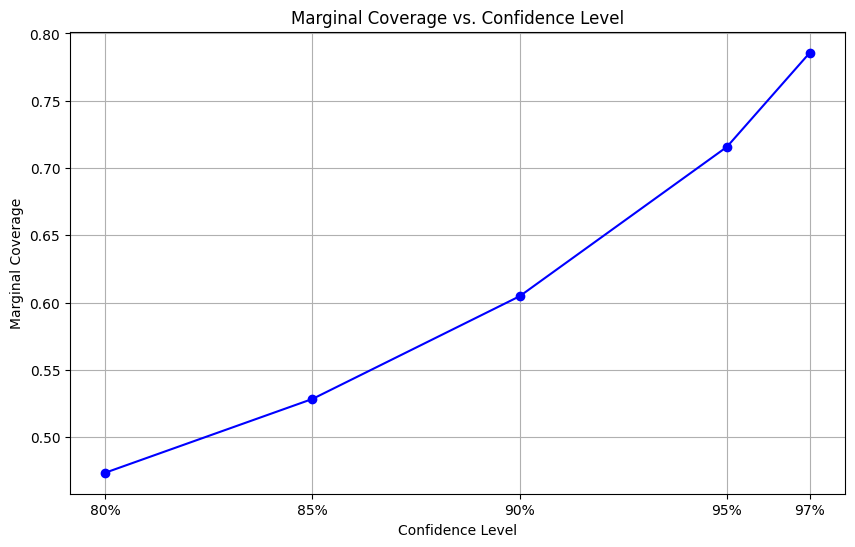

TypeError: imsave() missing 1 required positional argument: 'arr'

<Figure size 640x480 with 0 Axes>

In [15]:
# Convert alpha values to confidence levels for a more intuitive plot
confidence_levels = [1 - alpha for alpha in alpha_values]

plt.figure(figsize=(10, 6))
plt.plot(confidence_levels, coverage_results, marker='o', linestyle='-', color='b')
plt.title('Marginal Coverage vs. Confidence Level')
plt.xlabel('Confidence Level')
plt.ylabel('Marginal Coverage')
plt.grid(True)
plt.xticks(confidence_levels, labels=[f"{cl*100:.0f}%" for cl in confidence_levels])
plt.show()

plt.savefig('Marginal_Coverage_vs_Confidence_Level.png', format='png', dpi=300, bbox_inches='tight')

# plt.imsave('img_conformal.png')

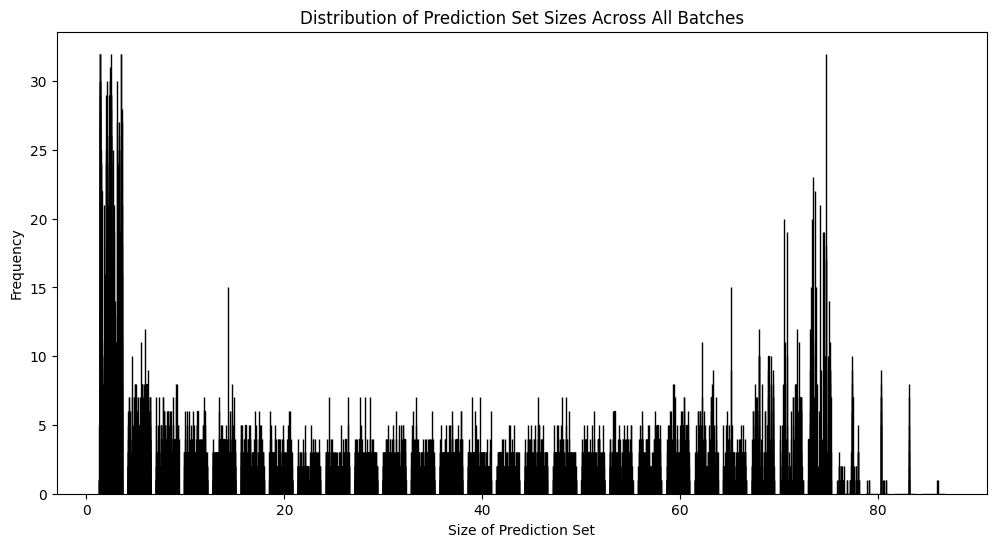

In [ ]:
# Plotting the distribution of prediction set sizes
plt.figure(figsize=(12, 6))
plt.hist(get_prediction_intervals_list, bins=30, edgecolor='black')
plt.title('Distribution of Prediction Set Sizes Across All Batches')
plt.xlabel('Size of Prediction Set')
plt.ylabel('Frequency')
plt.show()

In [2]:


# Assuming `prediction_sets` is a list of sets, each representing the prediction interval for an image
prediction_set_sizes = [len(s) for s in prediction_set]

# Simple visualization of prediction set sizes
plt.figure(figsize=(10, 6))
plt.bar(range(len(prediction_set_sizes)), prediction_set_sizes, color='skyblue')
plt.title('Prediction Set Sizes')
plt.xlabel('Image Index')
plt.ylabel('Size of Prediction Set')
plt.xticks(range(len(prediction_set_sizes)))
plt.show()

NameError: name 'prediction_set' is not defined

In [10]:
# import mmu

# Normalization layer to normalize the input to expected input of model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# Device to load the model on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Add additional layer to normalize the input to expected input shape of model
norm_model = nn.Sequential(
            normalize,
            model
        ).to(device)
norm_model = norm_model.eval()

# Apply attack on the test dataloader
def test_adv(dataloader, activation, final_eval=False):
    # Reset the metrics
    # Normal model metrics
    mAP.reset()  
    if final_eval and not set_chlg_eval:
        mAPv.reset() 
        mAPt.reset() 
        mAPi.reset()

    print("DataLoader Started:")
    for batch, (img, (y1, y2, y3, y4)) in enumerate(dataloader):
        # Extract data in form of batches
        img, y1, y2, y3, y4 = img.cuda(), y1.cuda(), y2.cuda(), y3.cuda(), y4.cuda()
        
        
        #################### Normal Testing #####################
        # Predictions of the model on clean images
        tool, verb, target, triplet = norm_model(img)
        # y1_cpu = to_cpu_list(y1)
        # tool_cpu = to_cpu_list(tool[1])

        # tool_cpu = tool_cpu.view(tool_cpu.size(0), -1)
        # tool_cpu -= tool_cpu.min(1, keepdim=True)[0]
        # tool_cpu /= tool_cpu.max(1, keepdim=True)[0]
        # tool_cpu = tool_cpu.view(batch_size, height, width)



        # print(tool)
        # print(tool_cpu)
        # print(np.array(y1_cpu).size)
        # print(y1_cpu , len(tool_cpu[1]))
        # print(np.array(y1_cpu) , np.array(tool_cpu) )
        # print(tool)
        # Compute the joint uncertainty on precision-recall curve
        # print(list(y1))
        # pr_err = mmu.PrecisionRecallCurveUncertainty.from_scores(np.array(y1_cpu), np.array(tool_cpu))

        # print(pr_err)
        # print(hi)
        # # Plot the uncertainty
        # pr_err.plot()

        # Final Evaluation 
        if final_eval:
            # Get logits and CAMs for each individual category
            cam_i, logit_i = tool
            cam_v, logit_v = verb
            cam_t, logit_t = target

            # Update the mAP metrics for each prediction of clean images
            mAPi.update(y1.float().detach().cpu(), activation(logit_i).detach().cpu()) # Log metrics 
            mAPv.update(y2.float().detach().cpu(), activation(logit_v).detach().cpu()) # Log metrics 
            mAPt.update(y3.float().detach().cpu(), activation(logit_t).detach().cpu()) # Log metrics 
        mAP.update(y4.float().detach().cpu(), activation(triplet).detach().cpu()) # Log metrics 

    # End the update of each metric
    if final_eval:
        mAPv.video_end()
        mAPt.video_end()
        mAPi.video_end()
        

# Main function for applying attack

In [29]:
################### Perform FGSM attack ##################

# Set FGSM parameters
eps = 8/255
exp_number = 1

# Logs Saving File
version_adv = 'Uncertainty-Estimation'
logfile  = f'weights/Logs/{version_adv}.log'

#%% log config
header1 = "** Experiment for Uncertainty Estimation **"
# header2 = "** Eps: {}/255 \t Exp Number: {} **".format(int(eps * 255) , exp_number)
# header3 = "** LR Config: Init: {} | Peak: {} | Warmup Epoch: {} | Rise: {} | Decay {} | train params {} | all params {} **".format([float(f'{sch.get_last_lr()[0]:.6f}') for sch in lr_schedulers], [float(f'{v:.6f}') for v in wp_lr], warmups, power, decay_rate, pytorch_train_params, pytorch_total_params)
maxlen  = len(header1)
# header1 = "{}{}{}".format('*'*((maxlen-len(header1))//2+1), header1, '*'*((maxlen-len(header1))//2+1) )
# header2 = "{}{}{}".format('*'*((maxlen-len(header2))//2+1), header2, '*'*((maxlen-len(header2))//2+1) )
# header3 = "{}{}{}".format('*'*((maxlen-len(header3))//2+1), header3, '*'*((maxlen-len(header3))//2+1) )
# maxlen  = max(len(header1), len(header2), len(header3))
print("\n\n\n{}\n{}\n{}\n\n".format("*"*maxlen, header1, "*"*maxlen), file=open(logfile, 'a+'))
print("Experiment started ...\n   logging outputs to: ", logfile)

# Reset the metrics globally
mAP.reset_global()
# mAP_adv.reset_global()

mAPi.reset_global()
mAPv.reset_global()
mAPt.reset_global()

# mAPi_adv.reset_global()
# mAPv_adv.reset_global()
# mAPt_adv.reset_global()

# Create a list to store image quality metrics for each batch
psnr_values_list = []
ssim_values_list = []
lpips_values_list = []
lpips = piq.LPIPS()

# Load each dataloader iteratively
for test_dataloader in test_dataloaders:
    # Pass the loader to the testing function
    test_adv(test_dataloader, activation, final_eval=True)
    
    print("Done...!. Printing Stats.")

# Compute the final update after each dataloader

####### Normal Metrics #####

if set_chlg_eval:
    mAP_i = mAP.compute_video_AP('i', ignore_null=set_chlg_eval)
    mAP_v = mAP.compute_video_AP('v', ignore_null=set_chlg_eval)
    mAP_t = mAP.compute_video_AP('t', ignore_null=set_chlg_eval)
else:
    mAP_i = mAPi.compute_video_AP(ignore_null=set_chlg_eval)
    mAP_v = mAPv.compute_video_AP(ignore_null=set_chlg_eval)
    mAP_t = mAPt.compute_video_AP(ignore_null=set_chlg_eval)

mAP_iv = mAP.compute_video_AP('iv', ignore_null=set_chlg_eval)
mAP_it = mAP.compute_video_AP('it', ignore_null=set_chlg_eval)
mAP_ivt = mAP.compute_video_AP('ivt', ignore_null=set_chlg_eval) 

####### Adversarial Metrics #####

# if set_chlg_eval:
#     mAP_i_adv = mAP_adv.compute_video_AP('i', ignore_null=set_chlg_eval)
#     mAP_v_adv = mAP_adv.compute_video_AP('v', ignore_null=set_chlg_eval)
#     mAP_t_adv = mAP_adv.compute_video_AP('t', ignore_null=set_chlg_eval)
# else:
#     mAP_i_adv = mAPi_adv.compute_video_AP(ignore_null=set_chlg_eval)
#     mAP_v_adv = mAPv_adv.compute_video_AP(ignore_null=set_chlg_eval)
#     mAP_t_adv = mAPt_adv.compute_video_AP(ignore_null=set_chlg_eval)

# mAP_iv_adv = mAP_adv.compute_video_AP('iv', ignore_null=set_chlg_eval)
# mAP_it_adv = mAP_adv.compute_video_AP('it', ignore_null=set_chlg_eval)
# mAP_ivt_adv = mAP_adv.compute_video_AP('ivt', ignore_null=set_chlg_eval) 

# Print the results into the logging file

######### Printing Baseline Model Stats #########

print('-'*50, file=open(logfile, 'a+'))
print('Test Results\nPer-category AP: ', file=open(logfile, 'a+'))
print('-'*50, file=open(logfile, 'a+'))
print(f'Mean AP:  I  |  V  |  T  |  IV  |  IT  |  IVT ', file=open(logfile, 'a+'))
print(f':::::: : {mAP_i["mAP"]:.4f} | {mAP_v["mAP"]:.4f} | {mAP_t["mAP"]:.4f} | {mAP_iv["mAP"]:.4f} | {mAP_it["mAP"]:.4f} | {mAP_ivt["mAP"]:.4f} ', file=open(logfile, 'a+'))
print('='*50, file=open(logfile, 'a+'))
print("Test results saved @ ", logfile)

######### Printing Adversarial Stats #########

# print('-'*50, file=open(logfile, 'a+'))
# print('Adversarial Test Results\nPer-category AP: ', file=open(logfile, 'a+'))
# print('-'*50, file=open(logfile, 'a+'))
# print(f'Mean AP:  I  |  V  |  T  |  IV  |  IT  |  IVT ', file=open(logfile, 'a+'))
# print(f':::::: : {mAP_i_adv["mAP"]:.4f} | {mAP_v_adv["mAP"]:.4f} | {mAP_t_adv["mAP"]:.4f} | {mAP_iv_adv["mAP"]:.4f} | {mAP_it_adv["mAP"]:.4f} | {mAP_ivt_adv["mAP"]:.4f} ', file=open(logfile, 'a+'))
# print('='*50, file=open(logfile, 'a+'))
# print('-'*50, file=open(logfile, 'a+'))
# print(f'PSNR: {np.mean(psnr_values_list):.4f}    | SSIM: {np.mean(ssim_values_list):.4f}     | LPIPS: {1 - np.mean(lpips_values_list):.4f}', file=open(logfile, 'a+'))
# print('-'*50, file=open(logfile, 'a+'))
# print("Test results saved @ ", logfile)



Experiment started ...
   logging outputs to:  weights/Logs/Uncertainty-Estimation.log


/home/umairnawaz/.conda/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/umairnawaz/.conda/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DataLoader Started:


TypeError: 'int' object is not callable

In [ ]:
eps_list = [4,8,16,32]

In [ ]:
################### Perform FGSM attack using the hyper params ##################
for eps in eps_list:
    # Set FGSM parameters
    eps = eps/255
    exp_number = 1
    
    # Logs Saving File
    version_adv = 'FGSM-Attack'
    logfile  = f'weights/LogsTooba/{version_adv}.log'
    
    #%% log config
    header1 = "** Experiment for FGSM Attack **"
    header2 = "** Eps: {}/255 **".format(int(eps * 255) )
    maxlen  = len(header1)

    print("\n\n\n{}\n{}\n{}\n{}\n\n".format("*"*maxlen, header1, header2, "*"*maxlen), file=open(logfile, 'a+'))
    print("Experiment started ...\n   logging outputs to: ", logfile)
    
    mAP.reset_global()
    mAP_adv.reset_global()
    
    mAPi.reset_global()
    mAPv.reset_global()
    mAPt.reset_global()
    
    mAPi_adv.reset_global()
    mAPv_adv.reset_global()
    mAPt_adv.reset_global()

    psnr_values_list = []
    ssim_values_list = []
    lpips_values_list = []
    lpips = piq.LPIPS()
    
    for test_dataloader in test_dataloaders:
        # index = 1
        test_adv(test_dataloader, model, activation, final_eval=True)
        
        # break
        ###### Normal ######
        print("Done...!. Printing Stats.")
    if set_chlg_eval:
        mAP_i = mAP.compute_video_AP('i', ignore_null=set_chlg_eval)
        mAP_v = mAP.compute_video_AP('v', ignore_null=set_chlg_eval)
        mAP_t = mAP.compute_video_AP('t', ignore_null=set_chlg_eval)
    else:
        mAP_i = mAPi.compute_video_AP(ignore_null=set_chlg_eval)
        mAP_v = mAPv.compute_video_AP(ignore_null=set_chlg_eval)
        mAP_t = mAPt.compute_video_AP(ignore_null=set_chlg_eval)
    
    mAP_iv = mAP.compute_video_AP('iv', ignore_null=set_chlg_eval)
    mAP_it = mAP.compute_video_AP('it', ignore_null=set_chlg_eval)
    mAP_ivt = mAP.compute_video_AP('ivt', ignore_null=set_chlg_eval) 
    
    ####### Adversarial Metrics #####
    
    if set_chlg_eval:
        mAP_i_adv = mAP_adv.compute_video_AP('i', ignore_null=set_chlg_eval)
        mAP_v_adv = mAP_adv.compute_video_AP('v', ignore_null=set_chlg_eval)
        mAP_t_adv = mAP_adv.compute_video_AP('t', ignore_null=set_chlg_eval)
    else:
        mAP_i_adv = mAPi_adv.compute_video_AP(ignore_null=set_chlg_eval)
        mAP_v_adv = mAPv_adv.compute_video_AP(ignore_null=set_chlg_eval)
        mAP_t_adv = mAPt_adv.compute_video_AP(ignore_null=set_chlg_eval)
    
    mAP_iv_adv = mAP_adv.compute_video_AP('iv', ignore_null=set_chlg_eval)
    mAP_it_adv = mAP_adv.compute_video_AP('it', ignore_null=set_chlg_eval)
    mAP_ivt_adv = mAP_adv.compute_video_AP('ivt', ignore_null=set_chlg_eval) 
    
    print('-'*50, file=open(logfile, 'a+'))
    print('Test Results: ', file=open(logfile, 'a+'))
    print('-'*50, file=open(logfile, 'a+'))
    print(f'Mean AP:  I  |  V  |  T  |  IV  |  IT  |  IVT ', file=open(logfile, 'a+'))
    print(f':::::: : {mAP_i["mAP"]:.4f} | {mAP_v["mAP"]:.4f} | {mAP_t["mAP"]:.4f} | {mAP_iv["mAP"]:.4f} | {mAP_it["mAP"]:.4f} | {mAP_ivt["mAP"]:.4f} ', file=open(logfile, 'a+'))
    print('='*50, file=open(logfile, 'a+'))
    print("Test results saved @ ", logfile)
    
    
    print('-'*50, file=open(logfile, 'a+'))
    print('Adversarial Test Results: ', file=open(logfile, 'a+'))
    print('-'*50, file=open(logfile, 'a+'))
    print(f'Mean AP:  I  |  V  |  T  |  IV  |  IT  |  IVT ', file=open(logfile, 'a+'))
    print(f':::::: : {mAP_i_adv["mAP"]:.4f} | {mAP_v_adv["mAP"]:.4f} | {mAP_t_adv["mAP"]:.4f} | {mAP_iv_adv["mAP"]:.4f} | {mAP_it_adv["mAP"]:.4f} | {mAP_ivt_adv["mAP"]:.4f} ', file=open(logfile, 'a+'))
    print('='*50, file=open(logfile, 'a+'))
    print('-'*50, file=open(logfile, 'a+'))
    print(f'PSNR: {np.mean(psnr_values_list):.4f}    | SSIM: {np.mean(ssim_values_list):.4f}     | LPIPS: {1 - np.mean(lpips_values_list):.4f}', file=open(logfile, 'a+'))
    print('-'*50, file=open(logfile, 'a+'))
    print("Test results saved @ ", logfile)
